<a href="https://colab.research.google.com/github/bndxn/dissertation/blob/main/Model_7_ConvLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import tqdm
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
training_sat_images = np.load('/content/drive/My Drive/Colab Notebooks/dissertation/Model 4/sat_images_train.npy')
training_sat_times = np.load('/content/drive/My Drive/Colab Notebooks/dissertation/Model 4/sat_times_train.npy')

validation_sat_images = np.load('/content/drive/My Drive/Colab Notebooks/dissertation/Model 4/sat_images_test.npy')
validation_sat_times = np.load('/content/drive/My Drive/Colab Notebooks/dissertation/Model 4/sat_times_test.npy')
pv_df = pd.read_pickle("/content/drive/My Drive/Colab Notebooks/dissertation/uk_pv/devon_pv_readings.pkl")
pv_df = pv_df.iloc[:,-1] # Only taking the means

print(pv_df.shape)
print(training_sat_images.shape)
print(training_sat_times.shape)
print(validation_sat_images.shape)
print(validation_sat_times.shape)

(233458,)
(24146, 128, 128)
(24146,)
(10139, 128, 128)
(10139,)


In [3]:
def pv_readings_for_sat_times(selected_sat_times, pv_readings_series):

  pv_readings_for_sat_times = []

  for time in selected_sat_times:
    try:
      reading = pv_readings_series[pv_readings_series.index == time][0]
      pv_readings_for_sat_times.append(reading)
    except IndexError:
      pv_readings_for_sat_times.append(0)
  
  pv_readings_for_sat_times = np.asarray(pv_readings_for_sat_times, dtype=object).astype('float32')

  np.nan_to_num(pv_readings_for_sat_times, copy=False)

  print('How many readings?', len(pv_readings_for_sat_times))
  print('Mean (nan values replaced with zero earlier)', pv_readings_for_sat_times.mean())

  return pv_readings_for_sat_times

train_pv = pv_readings_for_sat_times(training_sat_times, pv_df)
test_pv = pv_readings_for_sat_times(validation_sat_times, pv_df)

How many readings? 24146
Mean (nan values replaced with zero earlier) 541.58203
How many readings? 10139
Mean (nan values replaced with zero earlier) 600.9855


In [4]:
# Now we want to make blocks, one for each day

def get_list_of_days(list_of_timestamps):

  '''
    Takes a list of timestamps, including time
    Returns a list of unique days
  '''

  list_of_days = []

  for i in list_of_timestamps:
    list_of_days.append(pd.Timestamp(i).date())

  return list(dict.fromkeys(list_of_days))


def get_blocks_of_timestamps_for_day(date, list_of_timestamps):

  '''
    Takes a specific date and a list of timestamps (with times)
    Returns a list of blocks of 5 consecutive timestamps for that day
  '''

  timestamps_in_day = []

  # Make a list of all the timestamps for that date
  for i in list_of_timestamps: # Inefficient, checks all timestamps
    if pd.Timestamp(i).date() == date:
      timestamps_in_day.append(i)

  # Work out how many blocks this could make
  blocks_in_day = len(timestamps_in_day) // 5

  block_list = []

  for i in range(blocks_in_day):
    block_list.append(timestamps_in_day[i*5:(i+1)*5])

  return np.asarray(block_list)

def get_pv_and_sat_blocks(block_list, sat_data, pv_data, list_of_timestamps):

  '''
    Takes a list of blocks of 5 timestamps
    Returns sat images for t-4, t-3, ..., t, and pv_target for t+1
    
    Sat_data and pv_data need to be both for the same set (e.g. both train, or both split)
    because is done based on position, not timestamp
  '''
  sat_readings = np.zeros(shape=(len(block_list), 5, 128, 128))
  pv_targets = np.zeros(shape=(len(block_list))) 

  for i in range(block_list.shape[0]):
    for j in range(block_list.shape[1]):
      timestamp = block_list[i,j]

      index = np.where(list_of_timestamps == timestamp)[0][0]
      sat_readings[i,j] = sat_data[index]    
      pv_targets[i] = pv_data[index+1] 

  return sat_readings, pv_targets

def bundle_data(list_of_timestamps, sat_images, pv_data):

  '''
    Combines data sources, using functions above. 
    Iterates through list of days and creates blocks of data for each day
    Concatenates blocks across days
    Returns sat_readings array of blocks, and pv_readings array 
  '''

  list_of_days = get_list_of_days(list_of_timestamps)

  sat_readings_list = []
  pv_targets_list = []

  for day in list_of_days:

    block_list = get_blocks_of_timestamps_for_day(day, list_of_timestamps)
    sat_readings, pv_targets = get_pv_and_sat_blocks(block_list, sat_images, pv_data, list_of_timestamps)
    
    sat_readings_list.append(sat_readings)
    pv_targets_list.append(pv_targets)

    # print('Day :', day)
    # print(sat_readings.shape)
    # print(pv_targets.shape)

  sat_readings = np.concatenate(sat_readings_list)
  pv_targets = np.concatenate(pv_targets_list)


  return sat_readings, pv_targets


In [5]:
train_data, train_labels = bundle_data(training_sat_times, training_sat_images, train_pv)
test_data, test_labels = bundle_data(validation_sat_times, validation_sat_images, test_pv)

train_data /= 255
test_data  /= 255


max = np.nanmax(train_labels)

train_labels /= (max + 1)
test_labels /=  (max + 1)

from sklearn import utils

train_data, train_labels = utils.shuffle(train_data, train_labels)
test_data, test_labels = utils.shuffle(test_data, test_labels)


# Add channel dimension, taken from https://keras.io/examples/vision/conv_lstm/
train_data = np.expand_dims(train_data, axis=-1)
test_data = np.expand_dims(test_data, axis=-1)

In [6]:
print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)
print(test_labels.shape)

# train_data = train_data[:900]
# train_labels = train_labels[:900]
# test_data = test_data[:100]
# test_labels = test_labels[:100]

# print(train_data.shape)
# print(train_labels.shape)
# print(test_data.shape)
# print(test_labels.shape)

(4716, 5, 128, 128, 1)
(4716,)
(1980, 5, 128, 128, 1)
(1980,)


In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [12]:
# Inspired by Age prediction from images example : https://www.youtube.com/watch?v=9AnCNBL8c6Q&t=678s

inp = layers.Input(shape=(train_data.shape[1:]))

x = layers.ConvLSTM2D(filters=20, kernel_size=(3, 3), padding="same", return_sequences=True, activation="relu")(inp)
x = layers.MaxPooling3D(pool_size=(1,2,2))(x)

x = layers.ConvLSTM2D(filters=10, kernel_size=(3,3), return_sequences=True) (x)
x = layers.MaxPooling3D(pool_size=(1,3,3))(x)

x = layers.ConvLSTM2D(filters=5, kernel_size=(3,3), return_sequences=False, activation="relu") (x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)

x = layers.Flatten()(x)

x = layers.Dense(32, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)

x = layers.Dense(1, activation='linear')(x) 


model = keras.models.Model(inp, x)
model.compile(
    loss='mse', optimizer=keras.optimizers.Adam(),
)
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5, 128, 128, 1)]  0         
                                                                 
 conv_lstm2d_3 (ConvLSTM2D)  (None, 5, 128, 128, 20)   15200     
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 5, 64, 64, 20)    0         
 3D)                                                             
                                                                 
 conv_lstm2d_4 (ConvLSTM2D)  (None, 5, 62, 62, 10)     10840     
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 5, 20, 20, 10)    0         
 3D)                                                             
                                                                 
 conv_lstm2d_5 (ConvLSTM2D)  (None, 18, 18, 5)         2720

In [13]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 1
batch_size = 1

# Fit the model to the training data.
history = model.fit(
    train_data,
    train_labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(test_data, test_labels),
    callbacks=[early_stopping, reduce_lr],
)

4716/4716 [==============================] - 227s 47ms/step - loss: 0.0251 - val_loss: 0.0154 - lr: 0.0010


In [ ]:
plt.figure()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Loss under MAE')
plt.legend();


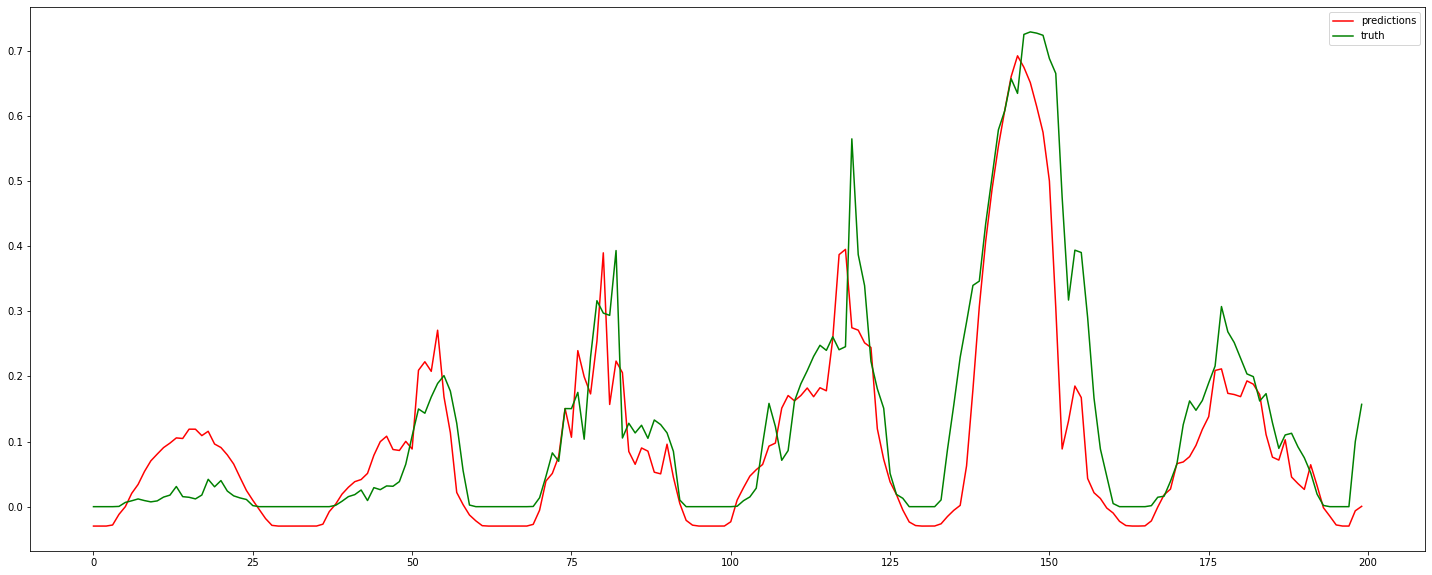

In [14]:
def plot_pred_and_truth(n,m, max):


  test_data, test_labels = bundle_data(validation_sat_times, validation_sat_images, test_pv)

  test_data  /= 255

  test_labels /=  (max + 1)

  test_at_end = np.expand_dims(test_data, axis=0)

  predictions = []

  for i in range(len(test_labels)):

    prediction = model.predict(test_at_end[:,i])
    predictions.append(prediction)

  fig = plt.figure(figsize=(25,10))
  plt.plot(np.arange(len(test_labels))[n:m], np.concatenate(np.concatenate(predictions))[n:m], color='red', label='predictions')
  plt.plot(np.arange(len(test_labels))[n:m], test_labels[n:m], color='green', label='truth')
  plt.legend()

plot_pred_and_truth(0,200,max)